# Imports

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# Network Class Architecture

## UNet Depth 4

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

class UNet4(tf.keras.Model):
    def __init__(self, input_size=(256, 256, 3), num_classes=1):
        super().__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        
        # Contracting Path (Encoder)
        self.conv1 = self.conv_block(64)
        self.pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        self.conv2 = self.conv_block(128)
        self.pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        self.conv3 = self.conv_block(256)
        self.pool3 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        self.conv4 = self.conv_block(512)
        self.pool4 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        
        # Bottleneck
        self.bottleneck = self.conv_block(1024)
        
        # Expansive Path (Decoder)
        self.upsample4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')
        self.upconv4 = self.conv_block(512)

        self.upsample3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')
        self.upconv3 = self.conv_block(256)

        self.upsample2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')
        self.upconv2 = self.conv_block(128)

        self.upsample1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')
        self.upconv1 = self.conv_block(64)
        
        # Output layer with a 1x1 convolution (sigmoid for binary classification)
        self.output_layer = layers.Conv2D(self.num_classes, (1, 1), activation='sigmoid', padding='same')

    def conv_block(self, filters, kernel_size=(3, 3), padding='same', strides=(1, 1)):
        return models.Sequential([
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
    
    def call(self, inputs):

        # Contracting path (encoder)
        enc1 = self.conv1(inputs)  # 256x256x3 -> 256x256x64
        pool1 = self.pool1(enc1)   # 256x256x64 -> 128x128x64

        enc2 = self.conv2(pool1)   # 128x128x64 -> 128x128x128
        pool2 = self.pool2(enc2)   # 128x128x128 -> 64x64x128

        enc3 = self.conv3(pool2)   # 64x64x128 -> 64x64x256
        pool3 = self.pool3(enc3)   # 64x64x256 -> 32x32x256

        enc4 = self.conv4(pool3)   # 32x32x256 -> 32x32x512
        pool4 = self.pool4(enc4)   # 32x32x512 -> 16x16x512
        
        # Bottleneck
        bottleneck = self.bottleneck(pool4)  # 16x16x512 -> 16x16x1024
        
        # Expansive path (decoder)
        up4 = self.upsample4(bottleneck)   # 16x16x1024 -> 32x32x512
        up4 = layers.Concatenate(axis=-1)([up4, enc4])  # 32x32x512 + 32x32x512 -> 32x32x1024
        up4 = self.upconv4(up4) # 32x32x1024 -> 32x32x512

        up3 = self.upsample3(up4) # 32x32x512 -> 64x64x256
        up3 = layers.Concatenate(axis=-1)([up3, enc3]) # 64x64x256 + 64x64x256 -> 64x64x512
        up3 = self.upconv3(up3) # 64x64x512 -> 64x64x256

        up2 = self.upsample2(up3) # 64x64x256 -> 128x128x128
        up2 = layers.Concatenate(axis=-1)([up2, enc2]) # 128x128x128 + 128x128x128 -> 128x128x256
        up2 = self.upconv2(up2) # 128x128x256 -> 128x128x128

        up1 = self.upsample1(up2) # 128x128x128 -> 256x256x64
        up1 = layers.Concatenate(axis=-1)([up1, enc1]) # 256x256x64 + 256x256x64 -> 256x256x128
        up1 = self.upconv1(up1) # 256x256x128 -> 256x256x64
        
        # Output layer
        output = self.output_layer(up1)  # 256x256x64 -> 256x256x1
        
        return output


## UNet Depth 3

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

class UNet3(tf.keras.Model):
    def __init__(self, input_size=(256, 256, 3), num_classes=1):
        super().__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        
        # Contracting Path (Encoder)
        self.conv1 = self.conv_block(64)
        self.pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        self.conv2 = self.conv_block(128)
        self.pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        self.conv3 = self.conv_block(256)
        self.pool3 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        
        # Bottleneck
        self.bottleneck = self.conv_block(512)
        
        # Expansive Path (Decoder)
        self.upsample3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')
        self.upconv3 = self.conv_block(256)

        self.upsample2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')
        self.upconv2 = self.conv_block(128)

        self.upsample1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')
        self.upconv1 = self.conv_block(64)
        
        # Output layer with a 1x1 convolution (sigmoid for binary classification)
        self.output_layer = layers.Conv2D(self.num_classes, (1, 1), activation='sigmoid', padding='same')

    def conv_block(self, filters, kernel_size=(3, 3), padding='same', strides=(1, 1)):
        return models.Sequential([
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
    
    def call(self, inputs):

        # Contracting path (encoder)
        enc1 = self.conv1(inputs)  # 256x256x3 -> 256x256x64
        pool1 = self.pool1(enc1)   # 256x256x64 -> 128x128x64

        enc2 = self.conv2(pool1)   # 128x128x64 -> 128x128x128
        pool2 = self.pool2(enc2)   # 128x128x128 -> 64x64x128

        enc3 = self.conv3(pool2)   # 64x64x128 -> 64x64x256
        pool3 = self.pool3(enc3)   # 64x64x256 -> 32x32x256
        
        # Bottleneck
        bottleneck = self.bottleneck(pool3)  # 32x32x256 -> 32x32x512
        
        # Expansive path (decoder)
        up3 = self.upsample3(bottleneck) # 32x32x512 -> 64x64x256
        up3 = layers.Concatenate(axis=-1)([up3, enc3]) # 64x64x256 + 64x64x256 -> 64x64x512
        up3 = self.upconv3(up3) # 64x64x512 -> 64x64x256

        up2 = self.upsample2(up3) # 64x64x256 -> 128x128x128
        up2 = layers.Concatenate(axis=-1)([up2, enc2]) # 128x128x128 + 128x128x128 -> 128x128x256
        up2 = self.upconv2(up2) # 128x128x256 -> 128x128x128

        up1 = self.upsample1(up2) # 128x128x128 -> 256x256x64
        up1 = layers.Concatenate(axis=-1)([up1, enc1]) # 256x256x64 + 256x256x64 -> 256x256x128
        up1 = self.upconv1(up1) # 256x256x128 -> 256x256x64
        
        # Output layer
        output = self.output_layer(up1)  # 256x256x64 -> 256x256x1
        
        return output


## UNet Depth 2

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

class UNet2(tf.keras.Model):
    def __init__(self, input_size=(256, 256, 3), num_classes=1):
        super().__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        
        # Contracting Path (Encoder)
        self.conv1 = self.conv_block(64)
        self.pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        self.conv2 = self.conv_block(128)
        self.pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        
        # Bottleneck
        self.bottleneck = self.conv_block(256)
        
        # Expansive Path (Decoder)

        self.upsample2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')
        self.upconv2 = self.conv_block(128)

        self.upsample1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')
        self.upconv1 = self.conv_block(64)
        
        # Output layer with a 1x1 convolution (sigmoid for binary classification)
        self.output_layer = layers.Conv2D(self.num_classes, (1, 1), activation='sigmoid', padding='same')

    def conv_block(self, filters, kernel_size=(3, 3), padding='same', strides=(1, 1)):
        return models.Sequential([
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
    
    def call(self, inputs):

        # Contracting path (encoder)
        enc1 = self.conv1(inputs)  # 256x256x3 -> 256x256x64
        pool1 = self.pool1(enc1)   # 256x256x64 -> 128x128x64

        enc2 = self.conv2(pool1)   # 128x128x64 -> 128x128x128
        pool2 = self.pool2(enc2)   # 128x128x128 -> 64x64x128
        
        # Bottleneck
        bottleneck = self.bottleneck(pool2)  # 64x64x128 -> 64x64x256
        
        # Expansive path (decoder)
        up2 = self.upsample2(bottleneck) # 64x64x256 -> 128x128x128
        up2 = layers.Concatenate(axis=-1)([up2, enc2]) # 128x128x128 + 128x128x128 -> 128x128x256
        up2 = self.upconv2(up2) # 128x128x256 -> 128x128x128

        up1 = self.upsample1(up2) # 128x128x128 -> 256x256x64
        up1 = layers.Concatenate(axis=-1)([up1, enc1]) # 256x256x64 + 256x256x64 -> 256x256x128
        up1 = self.upconv1(up1) # 256x256x128 -> 256x256x64
        
        # Output layer
        output = self.output_layer(up1)  # 256x256x64 -> 256x256x1
        
        return output


## UNet Depth 1

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

class UNet1(tf.keras.Model):
    def __init__(self, input_size=(256, 256, 3), num_classes=1):
        super().__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        
        # Contracting Path (Encoder)
        self.conv1 = self.conv_block(64)
        self.pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        
        # Bottleneck
        self.bottleneck = self.conv_block(128)
        
        # Expansive Path (Decoder)
        self.upsample1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')
        self.upconv1 = self.conv_block(64)
        
        # Output layer with a 1x1 convolution (sigmoid for binary classification)
        self.output_layer = layers.Conv2D(self.num_classes, (1, 1), activation='sigmoid', padding='same')

    def conv_block(self, filters, kernel_size=(3, 3), padding='same', strides=(1, 1)):
        return models.Sequential([
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
    
    def call(self, inputs):

        # Contracting path (encoder)
        enc1 = self.conv1(inputs)  # 256x256x3 -> 256x256x64
        pool1 = self.pool1(enc1)   # 256x256x64 -> 128x128x64
        
        # Bottleneck
        bottleneck = self.bottleneck(pool1)  # 128x128x64 -> 128x128x128
        
        # Expansive path (decoder)
        up1 = self.upsample1(bottleneck) # 128x128x128 -> 256x256x64
        up1 = layers.Concatenate(axis=-1)([up1, enc1]) # 256x256x64 + 256x256x64 -> 256x256x128
        up1 = self.upconv1(up1) # 256x256x128 -> 256x256x64
        
        # Output layer
        output = self.output_layer(up1)  # 256x256x64 -> 256x256x1
        
        return output


## SCSE

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the SCSEBlock as a custom layer
class SCSEBlock(layers.Layer):
    def __init__(self, filters):
        super(SCSEBlock, self).__init__()
        self.filters = filters
        
        # Channel Attention
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(filters // 2, activation="relu")
        self.dense2 = layers.Dense(filters, activation="sigmoid")
        self.reshape = layers.Reshape((1, 1, filters))
        
        # Spatial Attention
        self.spatial_conv = layers.Conv2D(1, kernel_size=1, activation="sigmoid")
    
    def call(self, inputs):
        # Channel Attention
        ch_attn = self.global_avg_pool(inputs)
        ch_attn = self.dense1(ch_attn)
        ch_attn = self.dense2(ch_attn)
        ch_attn = self.reshape(ch_attn)

        # Spatial Attention
        sp_attn = self.spatial_conv(inputs)

        # Apply Channel and Spatial Attention
        x = layers.Multiply()([inputs, ch_attn])
        x = layers.Multiply()([x, sp_attn])

        # Residual Connection
        # return layers.Add()([x, inputs])
        return x

## UNet depth 4 + SCSE

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

class UNet4SCSE(tf.keras.Model):
    def __init__(self, input_size=(256, 256, 3), num_classes=1):
        super().__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        
        # Contracting Path (Encoder)
        self.conv1 = self.conv_block(64)
        self.pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.scse1 = SCSEBlock(64)  # SCSE Block after conv1

        self.conv2 = self.conv_block(128)
        self.pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.scse2 = SCSEBlock(128)  # SCSE Block after conv2

        self.conv3 = self.conv_block(256)
        self.pool3 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.scse3 = SCSEBlock(256)  # SCSE Block after conv3

        self.conv4 = self.conv_block(512)
        self.pool4 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.scse4 = SCSEBlock(512)  # SCSE Block after conv4
        
        # Bottleneck
        self.bottleneck = self.conv_block(1024)
        self.scse_bottleneck = SCSEBlock(1024)  # SCSE Block at the bottleneck
        
        # Expansive Path (Decoder)
        self.upsample4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')
        self.upconv4 = self.conv_block(512)
        self.scse_up4 = SCSEBlock(512)  # SCSE Block after upconv4

        self.upsample3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')
        self.upconv3 = self.conv_block(256)
        self.scse_up3 = SCSEBlock(256)  # SCSE Block after upconv3

        self.upsample2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')
        self.upconv2 = self.conv_block(128)
        self.scse_up2 = SCSEBlock(128)  # SCSE Block after upconv2

        self.upsample1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')
        self.upconv1 = self.conv_block(64)
        self.scse_up1 = SCSEBlock(64)  # SCSE Block after upconv1
        
        # Output layer with a 1x1 convolution (sigmoid for binary classification)
        self.output_layer = layers.Conv2D(self.num_classes, (1, 1), activation='sigmoid', padding='same')

    def conv_block(self, filters, kernel_size=(3, 3), padding='same', strides=(1, 1)):
        return models.Sequential([
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
    
    def call(self, inputs):

        # Contracting path (encoder)
        enc1 = self.conv1(inputs)  # 256x256x3 -> 256x256x64
        enc1 = self.scse1(enc1)  # Apply SCSE Block after conv1
        pool1 = self.pool1(enc1)   # 256x256x64 -> 128x128x64

        enc2 = self.conv2(pool1)   # 128x128x64 -> 128x128x128
        enc2 = self.scse2(enc2)  # Apply SCSE Block after conv2
        pool2 = self.pool2(enc2)   # 128x128x128 -> 64x64x128

        enc3 = self.conv3(pool2)   # 64x64x128 -> 64x64x256
        enc3 = self.scse3(enc3)  # Apply SCSE Block after conv3
        pool3 = self.pool3(enc3)   # 64x64x256 -> 32x32x256

        enc4 = self.conv4(pool3)   # 32x32x256 -> 32x32x512
        enc4 = self.scse4(enc4)  # Apply SCSE Block after conv4
        pool4 = self.pool4(enc4)   # 32x32x512 -> 16x16x512
        
        # Bottleneck
        bottleneck = self.bottleneck(pool4)  # 16x16x512 -> 16x16x1024
        bottleneck = self.scse_bottleneck(bottleneck)  # Apply SCSE Block at bottleneck
        
        # Expansive path (decoder)
        up4 = self.upsample4(bottleneck)   # 16x16x1024 -> 32x32x512
        up4 = layers.Concatenate(axis=-1)([up4, enc4])  # 32x32x512 + 32x32x512 -> 32x32x1024
        up4 = self.upconv4(up4) # 32x32x1024 -> 32x32x512
        up4 = self.scse_up4(up4)  # Apply SCSE Block after upconv4

        up3 = self.upsample3(up4) # 32x32x512 -> 64x64x256
        up3 = layers.Concatenate(axis=-1)([up3, enc3]) # 64x64x256 + 64x64x256 -> 64x64x512
        up3 = self.upconv3(up3) # 64x64x512 -> 64x64x256
        up3 = self.scse_up3(up3)  # Apply SCSE Block after upconv3

        up2 = self.upsample2(up3) # 64x64x256 -> 128x128x128
        up2 = layers.Concatenate(axis=-1)([up2, enc2]) # 128x128x128 + 128x128x128 -> 128x128x256
        up2 = self.upconv2(up2) # 128x128x256 -> 128x128x128
        up2 = self.scse_up2(up2)  # Apply SCSE Block after upconv2

        up1 = self.upsample1(up2) # 128x128x128 -> 256x256x64
        up1 = layers.Concatenate(axis=-1)([up1, enc1]) # 256x256x64 + 256x256x64 -> 256x256x128
        up1 = self.upconv1(up1) # 256x256x128 -> 256x256x64
        up1 = self.scse_up1(up1)  # Apply SCSE Block after upconv1
        
        # Output layer
        output = self.output_layer(up1)  # 256x256x64 -> 256x256x1
        
        return output

## cSE

In [8]:
class cSEBlock(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(filters // 2, activation="relu")
        self.dense2 = layers.Dense(filters, activation="sigmoid")
        self.reshape = layers.Reshape((1, 1, filters))

    def call(self, inputs):
        ch_attn = self.global_avg_pool(inputs)
        ch_attn = self.dense1(ch_attn)
        ch_attn = self.dense2(ch_attn)
        ch_attn = self.reshape(ch_attn)
        return layers.Multiply()([inputs, ch_attn])

## UNet depth 4 + cSE

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

class UNet4cSE(tf.keras.Model):
    def __init__(self, input_size=(256, 256, 3), num_classes=1):
        super().__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        
        # Contracting Path (Encoder)
        self.conv1 = self.conv_block(64)
        self.pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.cse1 = cSEBlock(64)  # SCSE Block after conv1

        self.conv2 = self.conv_block(128)
        self.pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.cse2 = cSEBlock(128)  # SCSE Block after conv2

        self.conv3 = self.conv_block(256)
        self.pool3 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.cse3 = cSEBlock(256)  # SCSE Block after conv3

        self.conv4 = self.conv_block(512)
        self.pool4 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.cse4 = cSEBlock(512)  # SCSE Block after conv4
        
        # Bottleneck
        self.bottleneck = self.conv_block(1024)
        self.cse_bottleneck = cSEBlock(1024)  # SCSE Block at the bottleneck
        
        # Expansive Path (Decoder)
        self.upsample4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')
        self.upconv4 = self.conv_block(512)
        self.cse_up4 = cSEBlock(512)  # SCSE Block after upconv4

        self.upsample3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')
        self.upconv3 = self.conv_block(256)
        self.cse_up3 = cSEBlock(256)  # SCSE Block after upconv3

        self.upsample2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')
        self.upconv2 = self.conv_block(128)
        self.cse_up2 = cSEBlock(128)  # SCSE Block after upconv2

        self.upsample1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')
        self.upconv1 = self.conv_block(64)
        self.cse_up1 = cSEBlock(64)  # SCSE Block after upconv1
        
        # Output layer with a 1x1 convolution (sigmoid for binary classification)
        self.output_layer = layers.Conv2D(self.num_classes, (1, 1), activation='sigmoid', padding='same')

    def conv_block(self, filters, kernel_size=(3, 3), padding='same', strides=(1, 1)):
        return models.Sequential([
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
    
    def call(self, inputs):

        # Contracting path (encoder)
        enc1 = self.conv1(inputs)  # 256x256x3 -> 256x256x64
        enc1 = self.cse1(enc1)  # Apply SCSE Block after conv1
        pool1 = self.pool1(enc1)   # 256x256x64 -> 128x128x64

        enc2 = self.conv2(pool1)   # 128x128x64 -> 128x128x128
        enc2 = self.cse2(enc2)  # Apply SCSE Block after conv2
        pool2 = self.pool2(enc2)   # 128x128x128 -> 64x64x128

        enc3 = self.conv3(pool2)   # 64x64x128 -> 64x64x256
        enc3 = self.cse3(enc3)  # Apply SCSE Block after conv3
        pool3 = self.pool3(enc3)   # 64x64x256 -> 32x32x256

        enc4 = self.conv4(pool3)   # 32x32x256 -> 32x32x512
        enc4 = self.cse4(enc4)  # Apply SCSE Block after conv4
        pool4 = self.pool4(enc4)   # 32x32x512 -> 16x16x512
        
        # Bottleneck
        bottleneck = self.bottleneck(pool4)  # 16x16x512 -> 16x16x1024
        bottleneck = self.cse_bottleneck(bottleneck)  # Apply SCSE Block at bottleneck
        
        # Expansive path (decoder)
        up4 = self.upsample4(bottleneck)   # 16x16x1024 -> 32x32x512
        up4 = layers.Concatenate(axis=-1)([up4, enc4])  # 32x32x512 + 32x32x512 -> 32x32x1024
        up4 = self.upconv4(up4) # 32x32x1024 -> 32x32x512
        up4 = self.cse_up4(up4)  # Apply SCSE Block after upconv4

        up3 = self.upsample3(up4) # 32x32x512 -> 64x64x256
        up3 = layers.Concatenate(axis=-1)([up3, enc3]) # 64x64x256 + 64x64x256 -> 64x64x512
        up3 = self.upconv3(up3) # 64x64x512 -> 64x64x256
        up3 = self.cse_up3(up3)  # Apply SCSE Block after upconv3

        up2 = self.upsample2(up3) # 64x64x256 -> 128x128x128
        up2 = layers.Concatenate(axis=-1)([up2, enc2]) # 128x128x128 + 128x128x128 -> 128x128x256
        up2 = self.upconv2(up2) # 128x128x256 -> 128x128x128
        up2 = self.cse_up2(up2)  # Apply SCSE Block after upconv2

        up1 = self.upsample1(up2) # 128x128x128 -> 256x256x64
        up1 = layers.Concatenate(axis=-1)([up1, enc1]) # 256x256x64 + 256x256x64 -> 256x256x128
        up1 = self.upconv1(up1) # 256x256x128 -> 256x256x64
        up1 = self.cse_up1(up1)  # Apply SCSE Block after upconv1
        
        # Output layer
        output = self.output_layer(up1)  # 256x256x64 -> 256x256x1
        
        return output

## Instantiate the network

In [10]:
# Instantiate the model
unet = UNet4SCSE(input_size=(256, 256, 3), num_classes=1)

# Call the model with a random input to build the model
out = unet.call(tf.random.normal((1, 256, 256, 3)))
print(out.shape) # Make sure the output shape is correct

unet.summary()

(1, 256, 256, 1)


Model: "u_net4scse"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (1, 256, 256, 64)           │          39,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (1, 128, 128, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ scse_block (SCSEBlock)               │ ?                           │           4,257 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (1, 128, 128, 128)          │         222,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (1, 64, 64, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ scse_block_1 (SCSEBlock)             │ ?                           │          16,705 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (1, 64, 64, 256)            │         887,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (1, 32, 32, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ scse_block_2 (SCSEBlock)             │ ?                           │          66,177 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (1, 32, 32, 512)            │       3,544,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (1, 16, 16, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ scse_block_3 (SCSEBlock)             │ ?                           │         263,425 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (1, 16, 16, 1024)           │      14,166,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ scse_block_4 (SCSEBlock)             │ ?                           │       1,051,137 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (1, 32, 32, 512)            │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (1, 32, 32, 512)            │       7,083,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ scse_block_5 (SCSEBlock)             │ ?                           │         263,425 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (1, 64, 64, 256)            │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (1, 64, 64, 256)            │       1,772,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ scse_block_6 (SCSEBlock)             │ ?                           │          66,177 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (1, 128, 128, 128)          │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 32,807,562 (125.15 MB)

 Trainable params: 32,795,786 (125.11 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Utils

## Data loading utils

In [11]:
def load_image(image_path):
    """Load an image, decode it, and resize to 256x256"""
    img = tf.io.read_file(image_path)               # Read image
    img = tf.image.decode_jpeg(img, channels=3)       # Decode as JPG (assuming JPG images)
    img = tf.image.resize(img, (256, 256))           # Resize to target size
    img = img / 255.0                               # Normalize to range [0, 1]
    return img

def load_mask(mask_path):
    """Load a mask, decode it, and resize to 256x256"""
    mask = tf.io.read_file(mask_path)               # Read mask image
    mask = tf.image.decode_png(mask, channels=1)     # Decode as PNG (assuming masks are single-channel)
    mask = tf.image.resize(mask, (256, 256))         # Resize to target size
    mask = mask / 255.0                             # Normalize to range [0, 1]
    return mask

def load_data(image_folder, mask_folder):
    # Get image and mask file paths
    image_paths = sorted([os.path.join(image_folder, fname) for fname in os.listdir(image_folder)])
    mask_paths = sorted([os.path.join(mask_folder, fname) for fname in os.listdir(mask_folder)])
    
    # Shuffle the paths (optional)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # Load images and masks
    dataset = dataset.map(lambda x, y: (load_image(x), load_mask(y)))
    
    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=1000)  # Shuffle with buffer_size (adjust as needed)
    dataset = dataset.batch(batch_size=16)  # Batch size for training (adjust as needed)
    
    return dataset


# Training

## Prepare Training set

Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 1)


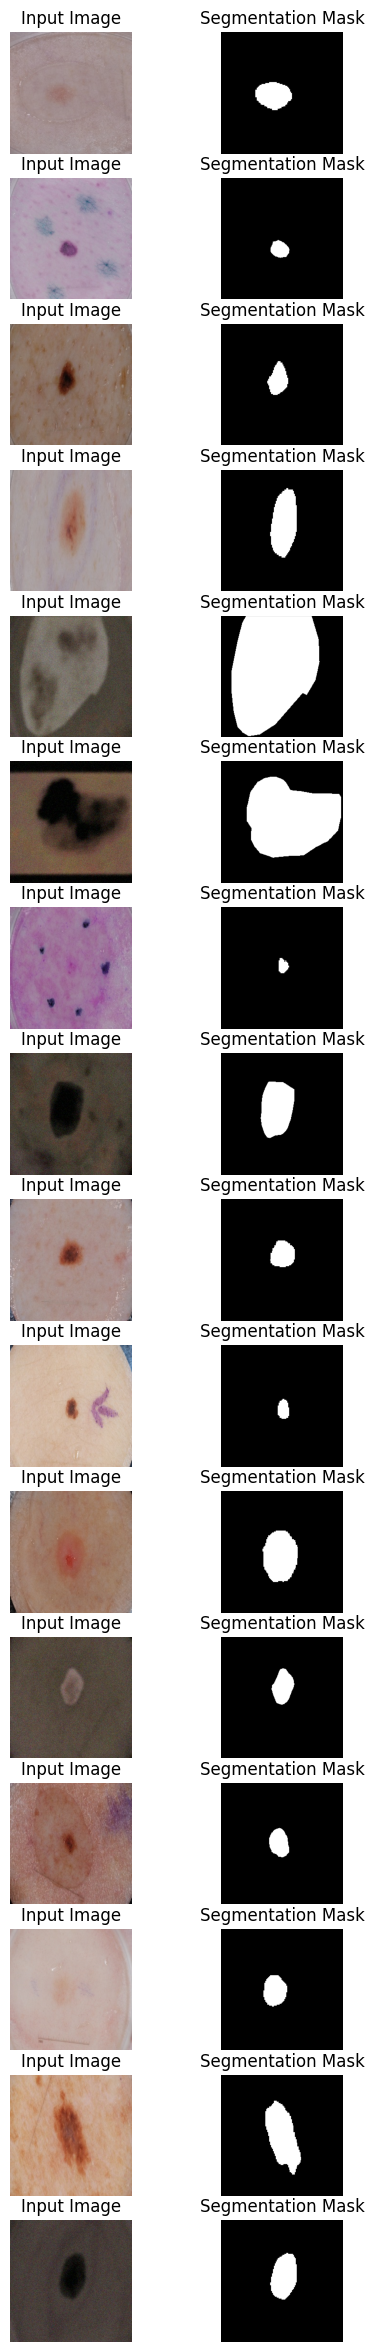

In [12]:
# Set the directory paths
train_image_folder = '/kaggle/input/isic-2016-2017-augmented/data_aug_4_DS/data_aug_4_DS/data_augmented_4_DS'
train_mask_folder = '/kaggle/input/isic-2016-2017-augmented/data_aug_4_DS/data_aug_4_DS/data_augmented_masks_4_DS'

# Load the dataset
train_dataset = load_data(train_image_folder, train_mask_folder)

# Check the dataset shapes (optional)
for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(5, 30))  # Adjust figure size

    for i in range(16):  # Loop through first batch
        # Display the input image
        plt.subplot(16, 2, 2 * i + 1)  # Arrange in 16 rows, 2 columns
        plt.imshow(images[i].numpy())  # Convert tensor to NumPy
        plt.title("Input Image")
        plt.axis("off")

        # Display the corresponding mask
        plt.subplot(16, 2, 2 * i + 2)
        plt.imshow(masks[i].numpy().squeeze(), cmap="gray")  # Ensure grayscale
        plt.title("Segmentation Mask")
        plt.axis("off")

    plt.show()

## Prepare Validation set

Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 1)


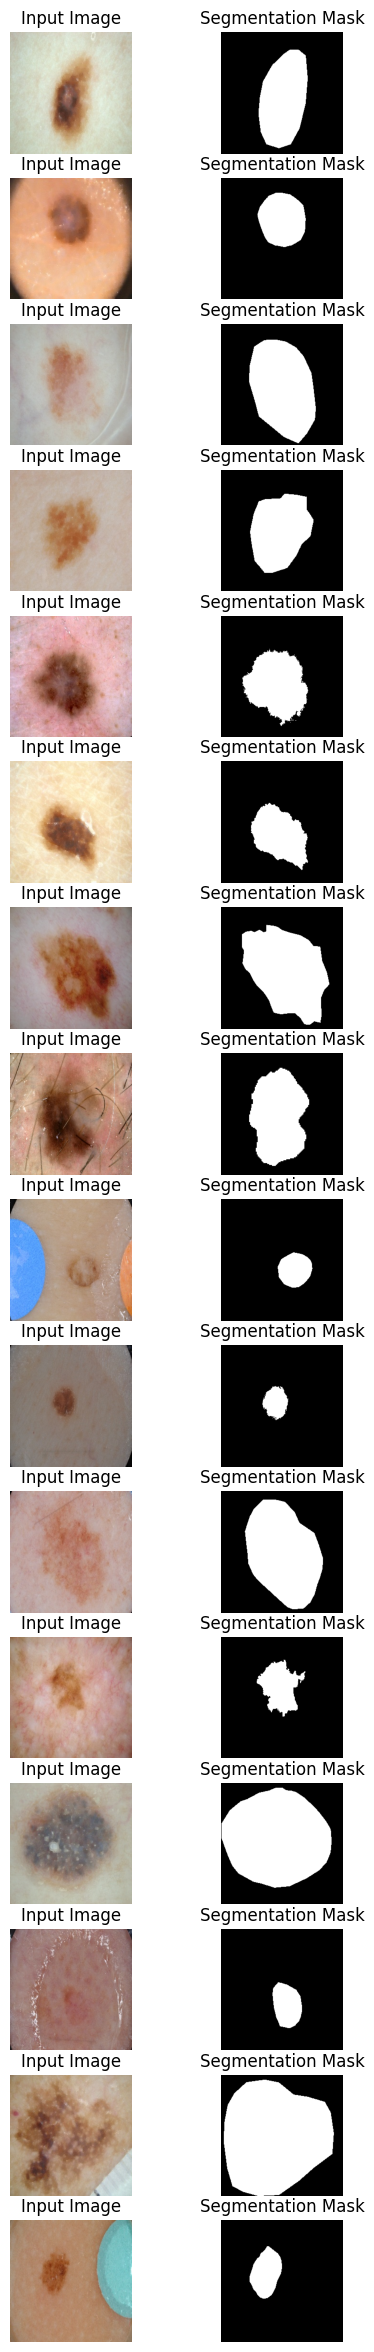

In [13]:
# Set the directory paths
valid_image_folder = '/kaggle/input/isic-2016-2017/split/val_images'
valid_mask_folder = '/kaggle/input/isic-2016-2017/split/val_masks'

# Load the dataset
valid_dataset = load_data(valid_image_folder, valid_mask_folder)

# Check the dataset shapes (optional)
for images, masks in valid_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(5, 30))  # Adjust figure size

    for i in range(16):  # Loop through first batch
        # Display the input image
        plt.subplot(16, 2, 2 * i + 1)  # Arrange in 16 rows, 2 columns
        plt.imshow(images[i].numpy())  # Convert tensor to NumPy
        plt.title("Input Image")
        plt.axis("off")

        # Display the corresponding mask
        plt.subplot(16, 2, 2 * i + 2)
        plt.imshow(masks[i].numpy().squeeze(), cmap="gray")  # Ensure grayscale
        plt.title("Segmentation Mask")
        plt.axis("off")

    plt.show()

### Check GPU availability

In [14]:
# Determine the number of GPUs available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

print("TensorFlow version", tf.__version__)

print("GPU Details: ", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version 2.17.1
GPU Details:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Define metrics

In [15]:
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)  # Flatten tensors
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)  # Compute intersection
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)  # Dice loss

def bce_dice_loss(y_true, y_pred, bce_weight=0.1):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce_weight * bce + (1 - bce_weight) * dice  # Hybrid loss (adjust weighting if needed)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return (intersection + smooth) / (union + smooth)  # Jaccard Index (IoU)


## Callbacks

In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",   # Monitor validation loss
    patience=16,           # Stop if val_loss doesn't improve for 10 epochs
    restore_best_weights=True # Restore best weights after stopping
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # Monitor validation loss
    factor=0.5,           # Reduce LR by half when plateauing
    patience=5,           # Wait 5 epochs before reducing LR
    min_lr=1e-6           # Set a minimum learning rate
)

## Compile and Train

In [ ]:
# Compile the model
unet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0), 
    loss=bce_dice_loss,
    metrics=[jaccard_index])

# Train the model
history = unet.fit(
    train_dataset, 
    validation_data=valid_dataset,
    epochs=200, # Adjust the number of epochs as needed
    callbacks=[early_stopping, reduce_lr])

Epoch 1/200
890/890 ━━━━━━━━━━━━━━━━━━━━ 466s 437ms/step - jaccard_index: 0.4125 - loss: 0.4569 - val_jaccard_index: 0.5808 - val_loss: 0.2849 - learning_rate: 0.0010
Epoch 2/200
890/890 ━━━━━━━━━━━━━━━━━━━━ 351s 393ms/step - jaccard_index: 0.5379 - loss: 0.3215 - val_jaccard_index: 0.5974 - val_loss: 0.2727 - learning_rate: 0.0010
Epoch 3/200
890/890 ━━━━━━━━━━━━━━━━━━━━ 351s 392ms/step - jaccard_index: 0.5844 - loss: 0.2792 - val_jaccard_index: 0.5979 - val_loss: 0.2761 - learning_rate: 0.0010
Epoch 4/200
890/890 ━━━━━━━━━━━━━━━━━━━━ 351s 392ms/step - jaccard_index: 0.6099 - loss: 0.2573 - val_jaccard_index: 0.6210 - val_loss: 0.2756 - learning_rate: 0.0010
Epoch 5/200
890/890 ━━━━━━━━━━━━━━━━━━━━ 350s 392ms/step - jaccard_index: 0.6271 - loss: 0.2437 - val_jaccard_index: 0.6597 - val_loss: 0.2239 - learning_rate: 0.0010
Epoch 6/200
890/890 ━━━━━━━━━━━━━━━━━━━━ 351s 392ms/step - jaccard_index: 0.6354 - loss: 0.2375 - val_jaccard_index: 0.6606 - val_loss: 0.2297 - learning_rate: 0.001

## Save the model

In [ ]:
# Save the model in native Keras format
unet.save('/kaggle/working/unet_model.keras')

# Save only the model weights in HDF5 format
unet.save_weights("/kaggle/working/unet_weights.weights.h5")

# Loading

## Load from scratch

In [ ]:
# Load the model from scratch
unet = tf.keras.models.load_model("/kaggle/working/unet_model.keras", custom_objects={"UNet":UNet4, "dice_loss": dice_loss, "jaccard_index": jaccard_index})

## Load only weights

In [ ]:
# Instantiate the model
unet = UNet4cSE(input_size=(256, 256, 3), num_classes=1)

# Call the model with a random input to build the model
out = unet.call(tf.random.normal((1, 256, 256, 3)))

# Restore the weights
unet.load_weights("/kaggle/input/unet_aug/keras/default/1/unet_cse_aug_4.weights.h5")


# Testing

## Preparing Testing set

In [ ]:
# Set the directory paths
test_image_folder = '/kaggle/input/isic-2016-2017/split/test_images'
test_mask_folder = '/kaggle/input/isic-2016-2017/split/test_masks'

# Load the dataset
test_dataset = load_data(test_image_folder, test_mask_folder)

# Check the dataset shapes (optional)
for images, masks in test_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

## Compile and Evaluate

In [ ]:
# Compile the model
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=bce_dice_loss, metrics=[jaccard_index])

In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = unet.evaluate(test_dataset)

# Visualizations

In [ ]:
test_images_dir = '/kaggle/input/isic-2016-2017/split/test_images'
test_masks_dir = '/kaggle/input/isic-2016-2017/split/test_masks'

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Get sorted image filenames (only images, not masks)
image_filenames = sorted([f for f in os.listdir(test_images_dir) if f.endswith(".jpg")])

# Iterate Over Images and Select Corresponding Mask
image_list = []
y_true_list = []
y_pred_list = []

for img_filename in image_filenames:
    img_path = os.path.join(test_images_dir, img_filename)

    # Construct the corresponding mask filename
    mask_filename = img_filename.replace(".jpg", "_segmentation.png")
    mask_path = os.path.join(test_masks_dir, mask_filename)

    # Load image and mask using your existing functions
    image_np = load_image(img_path).numpy()
    mask_tensor = load_mask(mask_path)  # Full mask path is passed correctly

    if mask_tensor is None:
        print(f" Skipping: No mask found for {img_filename}")
        continue  # Skip this image if the mask is missing

    mask_np = mask_tensor.numpy()

    # Get model prediction
    predicted_mask = unet.predict(np.expand_dims(image_np, axis=0), verbose=0)  # Add batch dimension

    # Threshold prediction to binary mask
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Store correctly paired results
    image_list.append(image_np)
    y_true_list.append(mask_np)
    y_pred_list.append(predicted_mask.squeeze())  # Remove batch dimension

# Convert Lists to Arrays
image_data = np.array(image_list)  # Shape: (N, 256, 256, 3)
y_true = np.array(y_true_list)  # Shape: (N, 256, 256, 1)
y_pred = np.array(y_pred_list)  # Shape: (N, 256, 256, 1)


In [ ]:
# Visualize First Image-Mask-Prediction Pairs
num_images_to_show = 20
fig, axes = plt.subplots(num_images_to_show, 3, figsize=(20, 20))

for i in range(num_images_to_show):
    axes[i, 0].imshow(image_data[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(np.squeeze(y_true[i]), cmap="gray")
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(np.squeeze(y_pred[i]), cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

## Prediction on custom images

In [ ]:
custom_images_dir = '/kaggle/input/my-skin-lesions/my_normalized_skin_lesions'

# Get sorted image filenames (only images, not masks)
image_filenames = sorted([f for f in os.listdir(custom_images_dir) if f.endswith(".jpg")])

# Iterate Over Images and Select Corresponding Mask
image_list = []
y_pred_list = []

for img_filename in image_filenames:
    img_path = os.path.join(custom_images_dir, img_filename)

    # Load image and mask using your existing functions
    image_np = load_image(img_path).numpy()

    # Get model prediction
    predicted_mask = unet.predict(np.expand_dims(image_np, axis=0))  # Add batch dimension

    # Threshold prediction to binary mask
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Store correctly paired results
    image_list.append(image_np)
    y_pred_list.append(predicted_mask.squeeze())  # Remove batch dimension

# Convert Lists to Arrays
image_data = np.array(image_list)  # Shape: (N, 256, 256, 3)
y_pred = np.array(y_pred_list)  # Shape: (N, 256, 256, 1)


In [ ]:
# Visualize First Image-Mask-Prediction Pairs
num_images_to_show = 3
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(5, 5))

for i in range(num_images_to_show):
    axes[i, 0].imshow(image_data[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(np.squeeze(y_pred[i]), cmap="gray")
    axes[i, 1].set_title("Predicted Mask")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# History

In [ ]:
import json

# Save history to a JSON file
with open('/kaggle/working/training_history.json', 'w') as f:
    json.dump(history.history, f)

## Training and Validation Loss

In [ ]:
# Load history from JSON file
with open('/kaggle/working/training_history.json', 'r') as f:
    loaded_history = json.load(f)

# Example: Access training and validation loss
train_loss = loaded_history['loss']
val_loss = loaded_history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Training and Validation Jaccard Index

In [ ]:
# Load history from JSON file
with open('/kaggle/working/training_history.json', 'r') as f:
    loaded_history = json.load(f)

# Example: Access training and validation loss
train_jaccard_idx = loaded_history['jaccard_index']
val_jaccard_idx = loaded_history['val_jaccard_index']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_jaccard_idx, label='Training Jaccard Index', color='blue')
plt.plot(epochs, val_jaccard_idx, label='Validation Jaccard Index', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Jaccard Index')
plt.legend()
plt.grid(True)
plt.show()